In [0]:
import numpy as np
import io
from time import time
from math import sqrt
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from gensim.corpora import Dictionary

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.layers import Layer, LayerNormalization, Dropout, Dense, Embedding, Input
from tensorflow.keras.models import Model

***In this notebook, we tried to implement from scratch a Transformer model in Tensorflow / Keras, for a french - english translation.  We based our work on the paper " Attention is all you need" as well as the Pytorch implementation of the model.***

# The Transformer

The Transformer is a neural network architecture released by Google Research in 2017 in a paper called "Attention is All You Need" (https://arxiv.org/abs/1706.03762). This is landmark improvement and opens up a new paradigm in the field of sequence-to-sequence learning. In particuler, the Transformer and its extensions beated state-of-the-art results in several fields : machine translation, language modelling, text summarization, etc. In this notebook, we'll go deep into the model architecture and train it for french-to-english machine translation.

## Model

### Sequence-to-sequence model

Sequence-to-sequence learning arises when the model takes as input a sequence of elements and outputs another sequence. Here, the temporal aspect is often essential to the task. The main approach to solve this problem with deep learning is to build an encoder-decoder structure. The encoder takes the input sequence and create a compact representation of it. From this representation, the decoder generate the output sequence iteratively, elements by elements. Before the Transformer model, the main approach was to use a RNN to encode the input sequence and use the final hidden vector as a compact representation of the sequence. Then, the decoder, another RNN, could take this vector as input and generate elements one by one. Variants include using a CNN as an encoder to process input images. The Transformer has a simple encoder-decoder structure, with only feedforward layers. The core innovation is the attention mechanism, which we'll explore later.

In [0]:
class Transformer(Model):
    
    def __init__ (self, num_layers, d_model, num_heads, d_feedforward,
                  input_vocab_size, target_vocab_size, rate=0.1):
        super(Transformer, self).__init__()
        self.num_layers = num_layers

        # encoder word embedding
        self.encoder_word_embedding = Embedding(input_vocab_size, d_model)
        # encoder positional encoding
        self.encoder_positional_encoding = PositionalEncoding(d_model)
        # encoding layers
        self.encoding_layers = [EncoderLayer(d_model, num_heads, d_feedforward, rate)
                                for _ in range(num_layers)]

        # decoder word embedding
        self.decoder_word_embedding = Embedding(target_vocab_size, d_model)
        # decoder positional encoding
        self.decoder_positional_encoding = PositionalEncoding(d_model)
        # decoding layers
        self.decoding_layers = [DecoderLayer(d_model, num_heads, d_feedforward, rate) 
                                for _ in range(num_layers)]

        # generator
        self.generator = Generator(target_vocab_size)
        
    def encode(self, enc_x, enc_padding_mask):
        # Encoding - Embedding / Positional Encoding
        enc_x = self.encoder_word_embedding(enc_x)
        enc_x = self.encoder_positional_encoding(enc_x)
        # Encoding - Processing
        for i in range(self.num_layers):
            enc_x = self.encoding_layers[i](enc_x, enc_padding_mask)
        enc_output = enc_x
        return enc_output
    
    def decode(self, enc_output, enc_padding_mask, dec_x, look_ahead_mask):
        # Decoding - Embedding / Positional Encoding
        dec_x = self.decoder_word_embedding(dec_x)
        dec_x = self.decoder_positional_encoding(dec_x)
        # Decoding - Processing
        for i in range(self.num_layers):
            dec_x = self.decoding_layers[i](dec_x, enc_output, enc_padding_mask, look_ahead_mask)
        dec_output = dec_x
        return dec_output
    
    def generate(self, dec_output):
        # Generate
        output = self.generator(dec_output)
        return output
        
    def call(self, enc_x, dec_x, enc_padding_mask=None, look_ahead_mask=None):
        # Encode
        enc_output = self.encode(enc_x, enc_padding_mask)

        # Decode
        dec_output = self.decode(enc_output, enc_padding_mask, dec_x, look_ahead_mask)

        # Generate
        output = self.generator(dec_output)
        
        return output

The transformer has a encoder-decoder architecture: the encoder takes the input sequence and maps it onto a single latent vector representing the entire sequence. This vector is then transmitted to a decoder which decomposes it into the  corresponding target sequence.

Here, our task is machine translation so the input and output sequences consist of words, represented by their id in the language vocabulary (we will create it with the dataset in the following). First, we convert the word indices into word embeddings to get a vector representation with useful semantic properties. These word embeddings are randomly initialised and learned within the model. Then, we need to solve an issue from the Transformer architecture: unlike recurrent networks, here all words are processed in parallel. We're then loosing the temporal aspect of the sequence, i.e. their position in the sentence. A naive way to solve it is to add a specific value to the word embedding, depending on the position of this word in the sentence: this is called positional encoding. The value added is a combination of sine and cosine functions.

In [0]:
class PositionalEncoding(Layer):
    
    def __init__(self, d_model, rate=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()

        self.pe = np.zeros((max_len, d_model))

        position = np.arange(0, max_len, dtype='float32')
        position = np.expand_dims(position, axis=1)

        div_term = np.exp(np.arange(0, d_model, 2, dtype='float32') * (- np.log(1e4) / d_model))

        self.pe[:, 0::2] = np.sin(position * div_term)
        self.pe[:, 1::2] = np.cos(position * div_term)

        self.pe = np.expand_dims(self.pe,axis=0)
        self.pe = tf.cast(self.pe, dtype=tf.float32)

        self.dropout = Dropout(rate)

    def call(self, x):
        #x = x + tf.Variable(self.pe[:, :x.get_shape()[1]], trainable=False)
        x = x + self.pe[:, :x.shape[1]]
        return self.dropout(x)

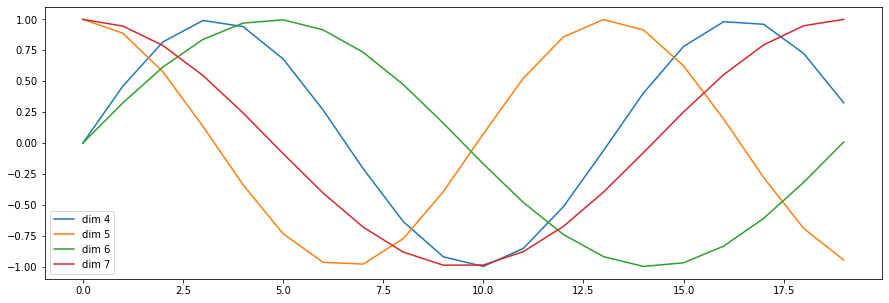

In [0]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(50, 0)
y = pe.call(tf.Variable(tf.zeros([1, 20, 50])))
plt.plot(np.arange(20), y[0, :, 4:8].numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

Next, the input sentence (word embeddings + positional encoding) is process consecutively by the encoding layers and we store the final output. The decoder operates in the same vein: it takes into account the encoded input sentence and generate output words one at a time. When a word is generated, it's added to the current output sentence and this partial sentence is given back into the decoder to generate the next word (as in RNN-like architectures). The main difference between this model and the previous RNN-based architecture is that at each step of the decoding process, it is possible for the decoder to actually see the encoded input setence, in addition to the current ouput sentence. The way the Transformer takes into account the encoded input sentence, differently at each step, is performed thanks to the attention trick.

### Attention module

The main feature of the Transformer architecture is what we call the attention. It allows the model to take into account the encoded representation of the input during the decoding process. For each word in the input sequence, the encoder produces a vector representation of this word (after several layers of embedding/feed forward layers). At the beginning of the decoding process, we then start with a vector per input word and we want to use them to produce the output sentence.

A simplistic approach would be to predict the first word thanks to the first encoded vector, etc. until the end of the process, but we wouldn't take into account the global sentence. Another approach would be to add up all the vectors into a very compact representation and just predict the whole sentence from that (as in the RNN-based machine translation). Between these two extremes, the Transformer tries to produce a weighted sum of the encoded vectors, with different weights depending on which word we want to translate. Intuitively, we think that the translation of a given word will give a great weight to its equivalent in the input sentence, and more diffuse weights to other input words, but nonzeros so that we still take care of the context on the sentence. This context (the other words we take into account from translating a given word) can be at any arbitrary distance we want from the word of interest, which is a huge improvement compared to RNN-based models.

To do that, we use a system of queries, keys and values (Q, K, V). Values are simply the encoded vectors we want to add up together in a weighted sum. More importantly, queries and keys enable us to generate the appropriate weights. Let's see an example. Suppose we've already predict (m-1) word in the output sentence and we want to predict the mth. The query produced from the last predicted word, here the (m-1)th word. Keys are produced from the input vectors. We take the dot product between our query and all of the keys, resulting with (unnormalized) weights. By taking the dot product between two vectors, which can be seen as a distance, we obtain the matching between them. Weights are then matching values between the current word (latest translated) and all input representations, we normalize these weights with a softmax function to get them between 0 and 1. Finally, the output of the attention layer is the weighted sum of the encoded inputs, with weights being the dot product between a query and keys (+ softmax).

In [0]:
def masked_fill(scores, mask, value=-1e9):
    mask = tf.expand_dims(mask, axis=1)
    scores = scores * mask + value * (1. - mask)
    return scores

def attention(query, key, value, mask=None):
    dim_k = tf.cast(query.shape[-1], dtype=tf.float32)
    scores = tf.matmul(query, key, transpose_b=True)
    scores = scores / tf.math.sqrt(dim_k)
    
    if mask is not None:
        scores = masked_fill(scores, mask)
        
    weights = tf.nn.softmax(scores, axis=-1)
    attention = tf.matmul(weights, value)
        
    return attention, weights

Mathematically, these is equivalent to the following steps: 

- First, three vectors are created from each input word vector, let's call this vector X. These three vectors are the _query_ Q, the _key_ K, and the _value_ V. They are created by multyplying the input word vector with three different matrices that are trained. <br>
$$q_{output} = W_Q x_{output}$$
$$K_{input} = W_K X_{input}$$
$$V_{input} = W_V X_{input} $$

- Then a score is calculated by taking the dot product of the query vector corresponding to the input word and the key vector of the word we want to score.
$$scores = q_{output} K_{input}^T$$

- This score is normalized. It is divided by a constant (here we use the square root of the dimension of the query vector) and passed through a softmax function. 
$$weigths = softmax ( scores / sqrt(d_k) )$$

- The value vectors are then multiplied by the normalized scores and added up to form the output of the self-attention layer for the input word at hand.
$$attention = weigths * V_{input}$$

### MultiHead Attention Layer 

In the Transformer model, the attention mechanism is improved by using multi-head attention. In this case, the attention process is applied several times for a same decoding step but with different matrices $W_Q$, $W_K$, $W_V$. UsEach attention head has a different set of matrices, this enables us to create different (query, key) couples. Thus, when one input vector is passed to the multi-head attention function, it produces several ouput attention vectors. We can imagine that each individual head will be specialized at looking for a special pattern inside the encoded input sentence, and therefore we mix all of these patterns to do the prediction.

Having several sets of matrices to compute the query, key and value vectors allows the attention layer to compute as many different combination of the encoded input as they are heads in the multi-head attention. Moreover, the multi-head attention improves the simple attention by expanding the model's ability to focus on different words of the sentence.

In [0]:
class MultiHeadAttention(Layer):

    def __init__(self, num_heads, d_model, dropout=0.1):
        super(MultiHeadAttention, self).__init__()

        assert d_model % num_heads == 0
        
        self.h = num_heads
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.attn = None
        
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        
        self.dense = Dense(d_model)        

    def call(self, v, k, q, mask):        
        # Calculate query/key/value matrix for each head
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        batch_size = tf.shape(q)[0]
        sent_len = tf.shape(v)[1]
        
        q = tf.reshape(q, (batch_size, self.h, -1, self.d_k))
        k = tf.reshape(k, (batch_size, self.h, -1, self.d_k))
        v = tf.reshape(v, (batch_size, self.h, -1, self.d_k))
        
        # Calculate attention for each head
        attn, weights = attention(q, k, v, mask)
        self.attn = weights
        
        # Concatenate and apply a final linear layer
        attn = tf.transpose(attn, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attn, (batch_size, -1, self.h * self.d_k))
        output = self.dense(concat_attention)
        
        return output

### Encoder Layer

Each encoder layer is made of a multi-head *self-attention* sublayer  followed by a feed-forward layer. After that is a residual connection followed by a normalization layer. 

In our use case, attention allows us to look at the whole sentence and make connections betweenthe different words and their relevant context. In self-attention, it consists of the attention each word pays to the other words of the sentence in order to quatify the context and specially the words that are th most relevent to this particular word. Therefore, self-attention consists of calculating the attention scores using the input sentence embedding as the key, query and value vectors.  

A residual connection is allows to add the original input back onto the output that we just calculated and the normalisation layer normalizes inputs through the features. These operations are also applied around the sblayers of the decoder. 

In [0]:
class EncoderLayer(Layer) : 

    def __init__(self, d_model, num_heads, output_dim, rate=0.1,**kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        
        self.attention = MultiHeadAttention(num_heads, d_model)
        self.norm1 = LayerNormalization(axis=-1, epsilon=1e-6)
        
        self.feedforward = FeedForward(d_model, output_dim)
        self.norm2 = LayerNormalization(axis=-1, epsilon=1e-6)
        
        self.dropout = Dropout(rate)

    def call(self, x, padding_mask):
        # Self-Attention
        attention_output = self.attention(x, x, x, padding_mask)
        attention_output = self.dropout(attention_output)
        # Add & Normalize
        #x = self.norm1(x + attention_output)
        x = self.norm1(attention_output)

        # FeedForward
        feedforward_output = self.feedforward(x)
        feedforward_output = self.dropout(feedforward_output)
        # Add & Normalize
        output = self.norm2(x + feedforward_output)

        return output

### FeedForward

- The Transformer model contains a stack of encoders and a stack of decoders. Each encoder and each decoder contains a feed-forward layer which consists of two linear transformations seperated by a ReLU activation. The weights for each of these feed-forward layers varies for each encoder/decoder.

In [0]:
class FeedForward(Layer):
    
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.l_1 = Dense(d_ff, activation='relu')
        self.l_2 = Dense(d_model)
        self.dropout = Dropout(dropout)

    def call(self, x):
        return self.dropout(self.l_2(self.l_1(x)))

### Decoder Layer

Each decoder layer is made of a masked self-attention sublayer followed by a multihead *attention* layer and a feed-forward. 

The self-attention layer is similar to the one in the encoder beside the fact that a mask is applied to the input so that the words of subsequent positions (_i.e._ the words coming after in the sentence) are not taken into consideration, which ensures that the predictions for a position can depend only on the known outputs preceding it, as shown in the following image.
 The second attention layer, also called Encode-Decoder attention, performs a multi-head attention on the output of the encoder stack.

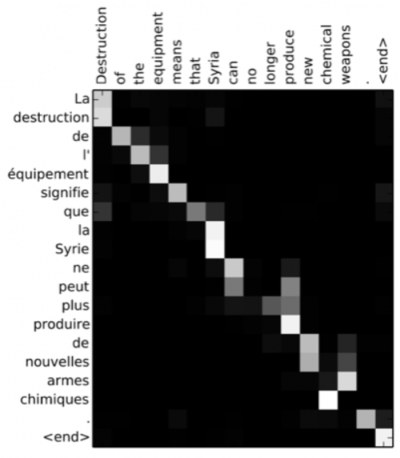

In [0]:
from IPython.display import Image
Image("transformer-fig3-400.jpg")

In [0]:
class DecoderLayer(Layer):

    def __init__(self, d_model, h, d_feedforward, rate=0.1,**kwargs):
        super(DecoderLayer, self).__init__(**kwargs)
        
        self.attention = MultiHeadAttention(h, d_model)
        self.norm1 = LayerNormalization(axis=-1, epsilon=1e-6)
        
        self.attention_mask = MultiHeadAttention(h, d_model)
        self.norm2 = LayerNormalization(axis=-1, epsilon=1e-6)
        
        self.feedforward = FeedForward(d_model, d_feedforward)
        self.norm3 = LayerNormalization(axis=-1, epsilon=1e-6)
        
        self.dropout = Dropout(rate)

    def call(self, x, enc_x, padding_mask, look_ahead_mask):
        # Self-Attention
        attention_output1 = self.attention(x, x, x, look_ahead_mask)
        attention_output1 = self.dropout(attention_output1)
        # Add & Normalize
        #output1 = self.norm1(x + attention_output1)
        output1 = self.norm1(attention_output1)
        
        # Encoder-Decoder Attention
        attention_output2 = self.attention(enc_x, enc_x, output1, padding_mask)
        attention_output2 = self.dropout(attention_output2)
        # Add & Normalize
        output2 = self.norm2(output1 + attention_output2)
        
        # FeedForward
        feedforward_output = self.feedforward(output2)
        feedforward_output = self.dropout(feedforward_output)
        # Add & Normalize
        output3 = self.norm3(output2 + feedforward_output)
        
        return output3

### Generator Layer

This layer is the final one. It comes after the stack of decoders. It is made of a linear layer that projects the encoder stack output into a representation space that has the size of the vocabulary. The output of the linear layer is then passed to a softmax layer that indicates what word, in the vocabulary, is the output

In [0]:
class Generator(Layer):
    
    def __init__(self, d_model):
        super(Generator, self).__init__()
        self.proj = Dense(d_model)
        
    def call(self, x):
        return tf.compat.v1.nn.log_softmax(self.proj(x), dim=-1)

### The overall architecture

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The full Transformer architecture corresponds to the picture below, that comes from https://nlp.seas.harvard.edu/2018/04/03/attention.html

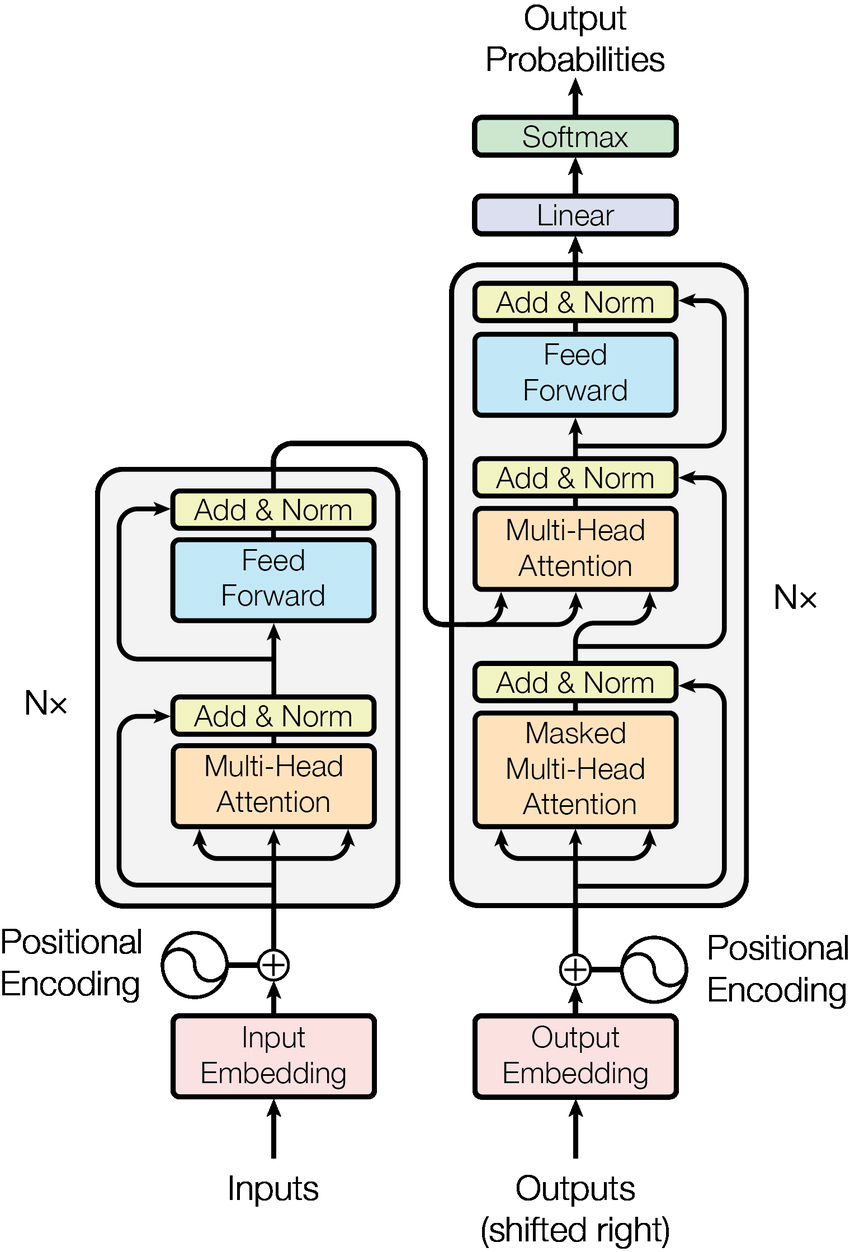

In [0]:
Image("The-Transformer-model-architecture.png")



The transformer has a sequence-to-sequence / encoder-decoder architecture: the encoder takes the input sequence and maps it onto a single latent vector representing the entire sequence. This vector is then transmitted to a decoder which decomposes it into the  corresponding target sequence.

The Encoder and Decoder are composed of modules that can be added on top of each other and are mainly MultiHead Attention and Feed Forward layers. 






## Toy Dataset

### Preprocessing

 The Preprocessing of the data consists on transforming the sentences into vectors of integers using the following steps : 

*   Tokenising the words which means turning them into word ids with the Tokenizer function. This process is done by taking off all of the punctuation and extracting the unique words of the vocabulary, and then giving each one a unique integer id.

*   Adding padding to the vectors to make sure the english and french sequences have the same length with the keras pad_sequence function.

Following that, we created the dataset and turned the sequences of integers into tensorflow tensors to be able to give it to our model. 

In [0]:
def preprocess(docs, tokenizer):
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower() # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx]) # Split into words.
    docs = [['<start>'] + [token for token in doc if not token.isnumeric()] + ['<end>'] for doc in docs]
    return docs

### Masks

There is also a change to the self-attention sub-layer in the decoder stack to prevent the following positions from being occupied. This masking,combined with the fact that the recesses of the outputs are offset by one position, ensures that predictions for position **i** can only depend on known outputs at positions below **i**.

In [0]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return (subsequent_mask == 0)

def make_masks(src, tgt):
    src_mask = np.expand_dims((src != 0), axis=-2) * 1.
    trg = tgt[:,:-1]
    tgt_mask = np.expand_dims((trg != 0), axis=-2) * 1.
    ahead_mask = (tgt_mask * subsequent_mask(trg.shape[-1])) * 1.

    src_mask = src_mask.astype('float32')
    ahead_mask = ahead_mask.astype('float32')
    return trg, src_mask, ahead_mask

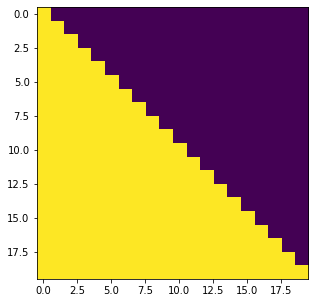

In [0]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

### Create & preprocess dataset

Before training our model on the main dataset, we generated a small "toy" dataset of 5000 sentences all written with the same 4 words to translate. We preprocessed this data the same way we did for our main dataset, which explained below. 

In [0]:
## Toy Example
seq_len = 4
vocab_fr = ['bonjour', 'oui', 'non', 'etudiant']
vocab_en = ['hello', 'yes', 'no', 'student']

raw_data_fr = []
raw_data_en = []

for i in range(5000):
    #l = np.random.randint(1, seq_len-1)
    l = seq_len - 1
    word_index = np.random.randint(1, len(vocab_fr), l)
    tmp_fr = ' '.join([vocab_fr[j] for j in word_index])
    tmp_en = ' '.join([vocab_en[j] for j in word_index])
    raw_data_fr.append(tmp_fr)
    raw_data_en.append(tmp_en)

print('sentence example')
print('fr:', raw_data_fr[5])
print('en:', raw_data_en[5])

sentence example
fr: non oui etudiant
en: no yes student


In [0]:
tokenizer = RegexpTokenizer(r'\w+')

data_en = preprocess(raw_data_en, tokenizer)
data_fr = preprocess(raw_data_fr, tokenizer)

dict_fr = Dictionary(data_fr)
dict_en = Dictionary(data_en)

data_fr = [dict_fr.doc2idx(doc) for doc in data_fr]
data_en = [dict_en.doc2idx(doc) for doc in data_en]

In [0]:
print('Number of unique tokens (fr): %d' % len(dict_fr))
print('Number of documents (fr): %d' % len(data_fr))

print('Number of unique tokens (en): %d' % len(dict_en))
print('Number of documents (en): %d' % len(data_en))

Number of unique tokens (fr): 5
Number of documents (fr): 5000
Number of unique tokens (en): 5
Number of documents (en): 5000


In [0]:
seq_len = max(np.max([len(c) for c in data_fr]), np.max([len(c) for c in data_en]))
print('Maximum sequence length:', seq_len)

Maximum sequence length: 5


In [0]:
data_fr = [list(np.pad(c, (0, seq_len - len(c)))) for c in data_fr]
data_en = [list(np.pad(c, (0, seq_len - len(c)))) for c in data_en]

src = np.array(data_fr)
tgt = np.array(data_en)

In [0]:
trg, src_mask, ahead_mask = make_masks(src, tgt)

In [0]:
X_train = [src, trg, src_mask, ahead_mask]
y_train = tgt[:,1:]

### Create model & train

For the training, we can notice that having a very small vocabulary lead to the model overfitting on it very quickly starting the 11 epoch. 

In [0]:
enc_x = Input(shape=(seq_len,))
dec_x = Input(shape=(seq_len-1,))
enc_padding_mask = Input(shape=(1, seq_len))
look_ahead_mask = Input(shape=(seq_len-1, seq_len-1))

input_vocab_size = len(dict_fr)
target_vocab_size = len(dict_en)

d_model = 32
d_feedforward = 128
num_heads = 2
num_layers = 2
rate = 0.01
transfo = Transformer(num_layers, d_model, num_heads, d_feedforward, 
                      input_vocab_size, target_vocab_size, rate)

output = transfo.call(enc_x, dec_x, enc_padding_mask, look_ahead_mask)
model = Model(inputs=[enc_x, dec_x, enc_padding_mask, look_ahead_mask], outputs=output)
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 5, 32)        160         input_53[0][0]                   
__________________________________________________________________________________________________
input_54 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
positional_encoding_30 (Positio (None, 5, 32)        0           embedding_26[0][0]               
___________________________________________________________________________________________

In [0]:
opt = tf.keras.optimizers.Adam(0.001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    
model.compile(
    loss=loss,
    optimizer=opt,
    metrics=[accuracy]
)

In [0]:
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=100
)

Train on 5000 samples
Epoch 1/100
5000/5000 [==============================] - 8s 2ms/sample - loss: 0.9779 - sparse_categorical_accuracy: 0.4856
Epoch 2/100
5000/5000 [==============================] - 2s 405us/sample - loss: 0.3637 - sparse_categorical_accuracy: 0.8466
Epoch 3/100
5000/5000 [==============================] - 2s 411us/sample - loss: 0.0250 - sparse_categorical_accuracy: 0.9941
Epoch 4/100
5000/5000 [==============================] - 2s 405us/sample - loss: 0.0070 - sparse_categorical_accuracy: 0.9987
Epoch 5/100
5000/5000 [==============================] - 2s 407us/sample - loss: 0.0075 - sparse_categorical_accuracy: 0.9980
Epoch 6/100
5000/5000 [==============================] - 2s 401us/sample - loss: 0.0027 - sparse_categorical_accuracy: 0.9994
Epoch 7/100
5000/5000 [==============================] - 2s 400us/sample - loss: 0.0014 - sparse_categorical_accuracy: 0.9998
Epoch 8/100
5000/5000 [==============================] - 2s 410us/sample - loss: 7.1151e-04 - spar

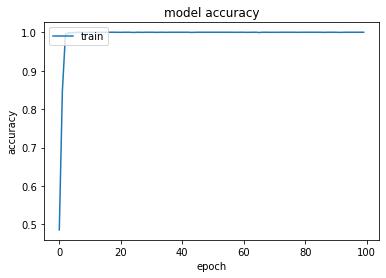

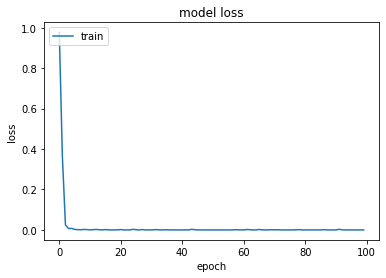

In [0]:
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Predict

In [0]:
## We tried to implement our own prediction function but ended up using the keras predict function 
def predict(x_test):
    memory = transfo.encode(np.array([x_test[0]]), np.array([x_test[2]]))
    tmp = np.zeros((1, len(x_test[1])), dtype='int32')
    tmp[0][0] = 1
    tmp = np.array([x_test[1]])
    l = []
    for i in range(seq_len-2):
        tmp_look_ahead = x_test[3][i].reshape((1, -1))
        dec = transfo.decode(memory, x_test[2], dec_x=tmp, look_ahead_mask=tmp_look_ahead)
        gen = transfo.generate(dec)
        out_argmax = np.argmax(gen, axis=2)[0][i]
        l.append(out_argmax)
        tmp[0][i+1] = out_argmax
    return tmp

In [0]:
# ind == the index of the sentence we want to translate
ind = 150
l = np.argmax(model.predict(X_train), axis=2)[ind]
print(l.shape, X_train[1].shape)
pred = [dict_en[x] for x in list(l)]
true = [dict_en[x] for x in list(X_train[1][ind])]
print('sentence predicted:', pred)
print('true sentence:     ', true[1:])

(4,) (5000, 4)
sentence predicted: ['yes', 'student', 'no', '<end>']
true sentence:      ['yes', 'student', 'no']


## French-to-English Translation

For the main dataset, we are using is named "Europarl". It is a parallel corpus extracted from the proceedings of the European Parliament and it includes versions in 21 European languages. We chose the the English-French corpus with a size of 194 Mb and containing 51,388,643 french words as well as 50,196,035 english ones with a total of 2,007,723 sentences.

In [0]:
def read_data(file_loc_, nb):
    data_list = list()
    with io.open(file_loc_) as fp:
        i = 0
        for line in fp:
            i += 1
            if i > nb:
                break
            try:
                text = line.strip()
            except IndexError:
                text = self.empty_line_flag
            data_list.append(text)
    return data_list

In [0]:
path_en = '/content/drive/My Drive/pfe/english.txt'
path_fr = '/content/drive/My Drive/pfe/french.txt'

In [0]:
nb = 10000
data_en = read_data(path_en, nb)
data_fr = read_data(path_fr, nb)

In [0]:
print(len(data_en), len(data_fr))
print(data_en[4])
print(data_fr[4])

10000 10000
In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union.
En attendant, je souhaiterais, comme un certain nombre de collègues me l'ont demandé, que nous observions une minute de silence pour toutes les victimes, des tempêtes notamment, dans les différents pays de l'Union européenne qui ont été touchés.


- Due to a lack of computing power, we decided to train our model only on a part of our dataset with sentences of less than 15 words each. 

- We trained our model on 450 epochs with a small batch size of 32 and with a learning rate of 0.01. The results were satisfying as we got an accuracy of more than 95%texte en gras and signficantly low loss. Then, we calculated the bleu score for a few predicted sentences to compare with the original ones. The BLEU score is a metric for evaluating a generated sentence to a reference sentence and it takes a value between 0.0 and 1, as a perfect translation would be a 1. In our case, we generally got a value above 0.9 on our tested samples.


In [0]:
tokenizer = RegexpTokenizer(r'\w+')

data_en = preprocess(data_en,tokenizer)
data_fr = preprocess(data_fr,tokenizer)

dict_fr = Dictionary(data_fr)
dict_en = Dictionary(data_en)


data_french = []
data_english = []
for doc1, doc2 in zip(data_fr, data_en):
  if len(doc1) < 15 and len(doc2) < 15 : 
    data_french.append(dict_fr.doc2idx(doc1))
    data_english.append(dict_en.doc2idx(doc2))

  
data_fr = data_french
data_en = data_english

In [0]:
print('Number of unique tokens (fr): %d' % len(dict_fr))
print('Number of documents (fr): %d' % len(data_fr))

print('Number of unique tokens (en): %d' % len(dict_en))
print('Number of documents (en): %d' % len(data_en))

Number of unique tokens (fr): 13902
Number of documents (fr): 1583
Number of unique tokens (en): 10295
Number of documents (en): 1583


In [0]:
seq_len = max(np.max([len(c) for c in data_fr]), np.max([len(c) for c in data_en]))
print(seq_len)

14


In [0]:
data_fr = [list(np.pad(c, (0, seq_len - len(c)))) for c in data_fr]
data_en = [list(np.pad(c, (0, seq_len - len(c)))) for c in data_en]

src = np.array(data_fr)
tgt = np.array(data_en)

src[4], tgt[4]

(array([ 1, 95,  3, 98, 94, 40, 88, 96,  2, 97,  0,  0,  0,  0]),
 array([ 1, 89, 92, 22,  6, 91,  2, 90,  0,  0,  0,  0,  0,  0]))

In [0]:
trg, src_mask, ahead_mask = make_masks(src, tgt)

In [0]:
X_train = [src, trg, src_mask, ahead_mask]
y_train = tgt[:,1:]

In [0]:
enc_x = Input(shape=(seq_len,))
dec_x = Input(shape=(seq_len-1,))
enc_padding_mask = Input(shape=(1, seq_len))
look_ahead_mask = Input(shape=(seq_len-1, seq_len-1))

input_vocab_size = len(dict_fr)
target_vocab_size = len(dict_en)

d_model = 32
d_feedforward = 128
num_heads = 2
num_layers = 2
rate = 0.01
transfo = Transformer(num_layers, d_model, num_heads, d_feedforward, 
                      input_vocab_size, target_vocab_size, rate)

output = transfo.call(enc_x, dec_x, enc_padding_mask, look_ahead_mask)
model = Model(inputs=[enc_x, dec_x, enc_padding_mask, look_ahead_mask], outputs=output)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 14)]         0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 14, 32)       444864      input_41[0][0]                   
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, 13)]         0                                            
__________________________________________________________________________________________________
positional_encoding_24 (Positio (None, 14, 32)       0           embedding_20[0][0]               
___________________________________________________________________________________________

In [0]:
opt = tf.keras.optimizers.Adam(0.001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    
model.compile(
    loss=loss,
    optimizer=opt,
    metrics=[accuracy]
)

In [0]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=450
)

Train on 1583 samples
Epoch 1/450
1583/1583 [==============================] - 10s 6ms/sample - loss: 8.0807 - sparse_categorical_accuracy: 0.3934
Epoch 2/450
1583/1583 [==============================] - 2s 1ms/sample - loss: 5.8601 - sparse_categorical_accuracy: 0.4148
Epoch 3/450
1583/1583 [==============================] - 2s 1ms/sample - loss: 4.5777 - sparse_categorical_accuracy: 0.4148
Epoch 4/450
1583/1583 [==============================] - 2s 1ms/sample - loss: 4.0979 - sparse_categorical_accuracy: 0.4148
Epoch 5/450
1583/1583 [==============================] - 2s 1ms/sample - loss: 3.8334 - sparse_categorical_accuracy: 0.4157
Epoch 6/450
1583/1583 [==============================] - 2s 1ms/sample - loss: 3.7025 - sparse_categorical_accuracy: 0.4386
Epoch 7/450
1583/1583 [==============================] - 2s 1ms/sample - loss: 3.6142 - sparse_categorical_accuracy: 0.4481
Epoch 8/450
1583/1583 [==============================] - 2s 1ms/sample - loss: 3.5418 - sparse_categorical_ac

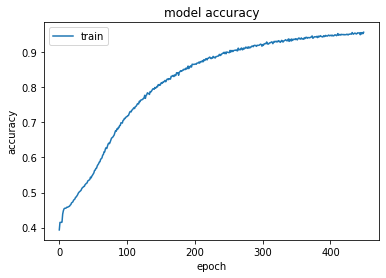

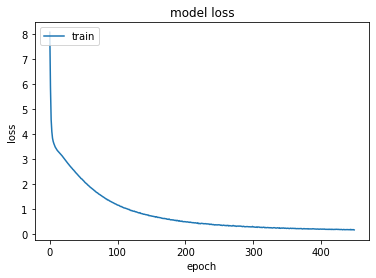

In [0]:
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.predict(X_train)

array([[[-2.84761219e+01, -2.66662560e+01, -2.41473446e+01, ...,
         -2.66651478e+01, -2.66643200e+01, -2.66648598e+01],
        [-3.45991516e+01, -3.50120697e+01, -1.72600150e-04, ...,
         -3.50159416e+01, -3.50134087e+01, -3.50140495e+01],
        [-3.70270195e+01, -3.54651642e+01, -1.16139908e+01, ...,
         -3.54711533e+01, -3.54676056e+01, -3.54693260e+01],
        ...,
        [ 0.00000000e+00, -3.98039093e+01, -4.69286652e+01, ...,
         -3.98060036e+01, -3.98048553e+01, -3.98059235e+01],
        [ 0.00000000e+00, -3.63706017e+01, -4.73696136e+01, ...,
         -3.63720589e+01, -3.63704948e+01, -3.63709641e+01],
        [ 0.00000000e+00, -3.87210579e+01, -4.09561043e+01, ...,
         -3.87236977e+01, -3.87222595e+01, -3.87235298e+01]],

       [[-2.71198444e+01, -2.71305294e+01, -1.37956238e+01, ...,
         -2.71369324e+01, -2.71325684e+01, -2.71354332e+01],
        [-2.66277695e+01, -2.66931362e+01, -2.62541237e+01, ...,
         -2.66960583e+01, -2.66945953e

In [0]:
# ind == the index of the sentence we want to translate
ind = 150
l = np.argmax(model.predict(X_train), axis=2)[ind]
print(l.shape, X_train[1].shape)
pred = [dict_en[x] for x in list(l)]
true = [dict_en[x] for x in list(X_train[1][ind])]
print('sentence predicted:', pred)
print('true sentence:     ', true[1:])



(13,) (1583, 13)
sentence predicted: ['frankly', 'i', 'believe', 'that', 'this', 'modernisation', 'has', 'been', 'satisfactory', '<end>', '<end>', '<end>', '<end>']
true sentence:      ['frankly', 'i', 'believe', 'that', 'this', 'modernisation', 'has', 'been', 'satisfactory', '<end>', '<end>', '<end>']


In [0]:
# Cumulative BLEU score Calculation
from nltk.translate.bleu_score import sentence_bleu
reference = [pred]
candidate = true[1:]
score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(score)


0.9200444146293233
